In [86]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import colorsys
from matplotlib.patches import Rectangle
import matplotlib.transforms
from PIL import Image
from scipy.optimize import curve_fit
from scipy.integrate import simpson

import csv
from csv import writer

import os
import statistics



78.0


C:\Users\vika\AppData\Local\Temp\ipykernel_14268\3648297997.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(I, y, 'ro', marker = 'o', markersize = 2)


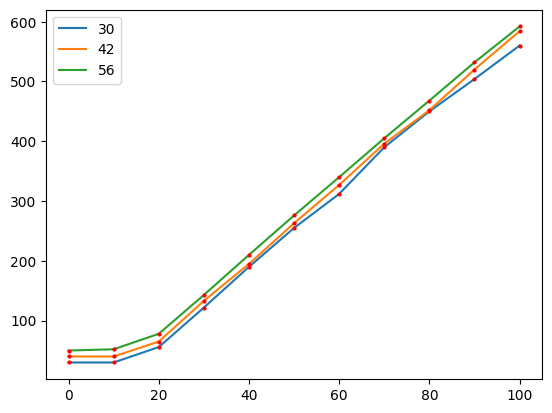

In [82]:
Pout_data = pd.read_csv('Pout_data.dat', sep = '\t')
Powers =['30', '42', '56']
Power_lambdas= dict.fromkeys(Powers) 
I = Pout_data.iloc[:, 0]
# print(I)

def get_power(P_nom, Iproc ):
    return Power_lambdas[P_nom](Iproc)
 
fig, ax = plt.subplots()
for power in Powers:
    y = [float(a.replace(',', '.')) for a in Pout_data['Pout' + power]]
    p = lambda i: np.interp(i, I, y) 
    Power_lambdas[power] = p

    x = np.linspace(0, 100, 101)
    plt.plot(x, get_power(power, x),  label = power)
    plt.plot(I, y, 'ro', marker = 'o', markersize = 2)
       
plt.legend()
    
    
    
print(get_power('56', 20) )

In [89]:

def read_spectrum(f:str):
    Pnom = f.split('//')[-1].split('.')[0].split('-')[0]
    Iproc = f.split('//')[-1].split('.')[0].split('-')[1]
    Pout = get_power(Pnom, float(Iproc))

    colnames = ['nm', 'dBm']
    scan = pd.read_csv(f, skiprows = 29, names=colnames)

    lmbdas = scan['nm']
    value = 10**(scan['dBm']/10)
    return {'Pout': Pout, 
            'lmbdas' :lmbdas,
            'value': value}

path = '600//'
dict_template = {
            'data':[]
            }
non_raman = {'30': dict_template, 
             '42': dict_template, 
             '56': dict_template}

raman = {'56': dict_template}

for name in os.listdir(path):
    f = os.path.join(path, name)
    # print(f, os.path.isfile(f), name[-4:])
    if os.path.isfile(f) and name[-4:] == '.CSV':
        spectrum = read_spectrum(f)
        split = name.split('.')[0].split('-')
        if len(split) == 2:
            non_raman[split[0]]['data'].append(spectrum)
        elif len(split) == 3:
            raman[split[0]]['data'].append(spectrum)


In [112]:
print(non_raman['56']['data'][-1])

{'Pout': 532.0, 'lmbdas': 0       1050.0
1       1050.1
2       1050.2
3       1050.3
4       1050.4
         ...  
1496    1199.6
1497    1199.7
1498    1199.8
1499    1199.9
1500    1200.0
Name: nm, Length: 1501, dtype: float64, 'value': 0       1.000000e-21
1       1.000000e-21
2       2.517677e-10
3       1.000000e-21
4       1.000000e-21
            ...     
1496    1.000000e-21
1497    1.031811e-09
1498    1.313711e-10
1499    1.000000e-21
1500    1.000000e-21
Name: dBm, Length: 1501, dtype: float64}


(1072.3, 1.0, 0.001950742743169147, 0.5813943071197513)

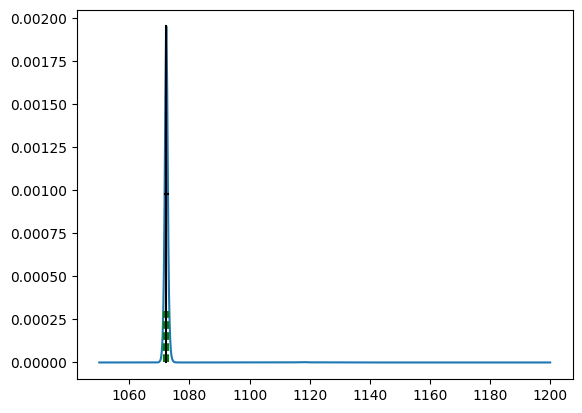

In [111]:
# print(raman)
# plt.plot(non_raman['30']['data'][0]['lmbdas'], non_raman['30']['data'][0]['value'] )

def analyze_spectrum(spectrum, lmbda_1, lmbda_2, out = 0):
    lmbdas = spectrum['lmbdas']
    value = spectrum['value']
    idx1 = np.where(lmbdas == lmbda_1)[0][0]
    idx2 = np.where(lmbdas == lmbda_2)[0][0]

    all_power = simpson(value, x = lmbdas)
    peak_power = simpson(value[idx1:idx2], x = lmbdas[idx1:idx2])


    power_share = peak_power/all_power
    power_peak = max(value)
    central_lmbda = lmbdas[np.where(value == power_peak)[0][0]]

    left = lmbdas[np.where(value >= power_peak/2)[0][0]]
    right = lmbdas[np.where(value >= power_peak/2)[0][-1]]
    width = right - left

    if out == 1:
        plt.plot(lmbdas, value)
        plt.plot([lmbda1, lmbda1], [0, m], 'g--')
        plt.plot([lmbda2, lmbda2], [0, m], 'g--')
        plt.plot([central_lmbda, central_lmbda], [0, power_peak], color = 'black')
        plt.plot([central_lmbda - width/2, central_lmbda + width/2], [power_peak/2, power_peak/2], color = 'black')  

    return central_lmbda, width, power_peak, power_share

lmbda1 = 1071.5
lmbda2 = 1073
m = 0.0003
analyze_spectrum(non_raman['56']['data'][-1], 1072, 1073, 1)